In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy import interp
pd.set_option('display.float_format', lambda x: '%.3f' % x)



In [6]:
df = pd.read_csv('FoodFacts.csv')

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,3,5,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Setup

In [7]:
# These columns probably don't contain info we're interested in.
df.drop(['code', 'created_t', 'last_modified_datetime'], axis=1, inplace=True)

Split the foods by country. Credit to [Christina](https://www.kaggle.com/christinampoid/d/openfoodfacts/world-food-facts/europe-habits)



In [8]:
#labels: list of Strings with country names
#returns the rows that have as country name any of the names in labels
def get_rows_country(labels):
    return df[df.countries.isin(labels)]

#labels: list of Strings with country names
#returns the categories and the percentage that appear in the rows of a particular country
def get_categories_counts(labels):
    rows = get_rows_country(labels)
    food_country = rows.main_category_en.value_counts() / len(rows)*100
    return food_country

#France
labels_france = ['France', 'en:FR', 'France,Europe','Belgique,France']
french_food = get_rows_country(labels_france)

#Spain
labels_spain = ['España','en:ES','Espagne','Spain']
spanish_food = get_rows_country(labels_spain)

#Germany
labels_germany = ['Deutschland','Germany','Allemagne','en:DE']
german_food = get_rows_country(labels_germany)

#United Kingdom
labels_uk = ['en:UK','United Kingdom','en:GB','uk','UK']
uk_food = get_rows_country(labels_uk)

#Belgium
labels_belgium = ['Belgique','en:BE','Belgique,France','Belgium','Belgique,France']
belgium_food = get_rows_country(labels_belgium)

#Italia
labels_italia = ['Italia','en:IT','Italie']
italian_food = get_rows_country(labels_italia)

#Switzerland
labels_switzerland = ['Suisse','Switzerland']
suisse_food = get_rows_country(labels_switzerland)

#Netherlands
labels_netherlands = ['Netherlands', 'Holland']
holland_food = get_rows_country(labels_netherlands)

#Denmark
labels_denmark = ['Denmark','Dänemark']
dannish_food = get_rows_country(labels_denmark)

#Portugal
labels_portugal = ['Portugal','en:portugal']
portuguese_food = get_rows_country(labels_portugal)

#Greece
labels_greece = ['Greece','en:GR','Grèce','en:greece']
greek_food = get_rows_country(labels_greece)

#Sweden
labels_sweden = ['Sweden','en:SE','en:sweden']
swedish_food = get_rows_country(labels_sweden)

#Norway
labels_norway = ['Norway','en:NO','en:norway']
norwegian_food = get_rows_country(labels_norway)

#Croatia
labels_croatia = ['Croatia','en:HR','en:croatia']
croatian_food = get_rows_country(labels_croatia)

#Albania
labels_albania = ['Albania','en:AL','en:albania']
albanian_food = get_rows_country(labels_albania)

labels_usa = ['United States', 'en:US', 'US', 'USA', 'en:united-states','United states', 'united states', 'United States of America']
usa = get_rows_country(labels_usa)
europe = pd.concat([french_food,
                    spanish_food,
                    german_food, 
                    uk_food, 
                    belgium_food, 
                    italian_food, 
                    suisse_food,
                    holland_food,
                    dannish_food, 
                    portuguese_food, 
                    greek_food, 
                    swedish_food,
                    norwegian_food,
                    croatian_food, 
                    albanian_food])

Let's keep only the numeric columns, and while we're at it, let's remove any columns that have only NA entries in either of the dataframes, as those won't help us compare European foods to USA foods.

In [9]:
usaNumOnly = usa.select_dtypes(include=[np.number])
europeNumOnly = europe.select_dtypes(include=[np.number])

usaNaCols = [col for col in usaNumOnly.columns if usaNumOnly[col].isnull().all()]
euroNaCols = [col for col in europeNumOnly.columns if europeNumOnly[col].isnull().all()]

combinedNaCols = usaNaCols + euroNaCols

usa = usa.drop(combinedNaCols, axis=1)
europeNumOnly = europeNumOnly.drop(combinedNaCols, axis=1)
print(europeNumOnly.shape)
print(usaNumOnly.shape)


(55942, 53)
(2413, 53)


Let's add a feature to differentiate the US from Euro foods. We'll fill na's with 0, assuming, perhaps naively, that if something isn't on a food's label, it's doesn't contain it.

In [10]:
usaNumOnly['isUS'] = 1
europeNumOnly['isUS'] = 0
train = pd.concat([usaNumOnly, europeNumOnly])
train = train.fillna(0, axis=0)


Lastly, let's drop a few more columns. Palm oil is required on food labels in Europe but not in the US. So we'll drop those. Palm oil is actually fairly interesting:
- https://www.theguardian.com/sustainable-business/2014/dec/12/eu-labelling-changes-palm-oil-consumer-change
- http://www.eurofoodlaw.com/labelling/analysis-palm-oil-no-longer-a-hidden-ingredient-108325.htm

We'll also drop the British and French nurtition scores.

In [11]:
colsToDrop = ['ingredients_from_palm_oil_n', 
              'ingredients_that_may_be_from_palm_oil_n', 
              'nutrition_score_uk_100g',
              'nutrition_score_fr_100g']
train = train.drop(colsToDrop, axis=1)
train.head()

,additives_n,energy_100g,energy_from_fat_100g,fat_100g,saturated_fat_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,omega_3_fat_100g,alpha_linolenic_acid_100g,trans_fat_100g,...,manganese_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,fruits_vegetables_nuts_100g,cocoa_100g,carbon_footprint_100g,isUS
20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
56,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
78,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
83,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1
87,3.000,761.000,275.000,7.580,4.040,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1


## EDA

Some helper functions.

In [32]:
def makeTrainingSet(colsToDrop=[]):
    X = train.drop(['isUS'] + colsToDrop, axis=1)
    y = train['isUS']
    return (X, y)

def makeCoefDf(clf, X):
    coef_df = pd.DataFrame({'value': clf.coef_[0], 'absVal': abs(clf.coef_[0]), 'feature': X.columns })
    return coef_df.sort_values(by='absVal', ascending=False)

def makeFeatureImpDf(clf, X):
    coef_df = pd.DataFrame({'value': clf.feature_importances_[0], 'feature': X.columns })
    return coef_df.sort_values(by='value', ascending=False)

Let's see which features correlate most strongly with whether a food is from Europe or the US.

In [12]:
corr_df = pd.DataFrame({'feature': [], 'pval': [], 'value': []})

from scipy.stats import pointbiserialr

for col in train.drop(['isUS'], axis= 1).columns:
    corr = pointbiserialr(train['isUS'].values, train[col].values)
    corr_df = corr_df.append(pd.Series({'feature': col, 'pval':corr.pvalue, 'value': corr.correlation, 'absVal': abs(corr.correlation)}), ignore_index=True)

corr_df.sort_values(by='absVal', ascending=False, inplace=True)
corr_df.iloc[0:10, :]

,feature,pval,value,absVal
2,energy_from_fat_100g,0.000,0.340,0.340
10,cholesterol_100g,0.000,0.199,0.199
9,trans_fat_100g,0.000,0.039,0.039
16,proteins_100g,0.000,-0.037,0.037
0,additives_n,0.000,-0.031,0.031
6,polyunsaturated_fat_100g,0.000,0.025,0.025
46,fruits_vegetables_nuts_100g,0.000,-0.022,0.022
42,chromium_100g,0.000,0.021,0.021
38,zinc_100g,0.000,0.021,0.021
1,energy_100g,0.000,-0.021,0.021


Let's take a closer look at energy_from_fat and cholesterol

In [13]:
train.groupby('isUS')[['energy_from_fat_100g', 'cholesterol_100g']].mean()

,energy_from_fat_100g,cholesterol_100g
isUS,,
0,0.063,0.000
1,171.939,0.007


In [33]:
usaFattiest = train[train['isUS'] == 1].energy_from_fat_100g.sort_values(ascending=False)
usa.ix[usaFattiest.index.values, :][['product_name', 'energy_from_fat_100g']].head(10)

,product_name,energy_from_fat_100g
5141,Lemon Ginger,3740.000
683,Virgin coconut oil,3590.000
641,Corn Oil,3350.000
3612,NaN,3350.000
2922,Mayonnaise,3220.000
2934,Mayonnaise,3220.000
2276,Grade AA Butter,2990.000
4653,Sweat Cream Butter,2990.000
1672,Real Mayonnaise,2990.000
1000,Real Mayonnaise,2990.000


In [35]:
euroFattiest = train[train['isUS'] == 0].energy_from_fat_100g.sort_values(ascending=False)
europe.ix[euroFattiest.index.values, :][['product_name', 'energy_from_fat_100g']].head(10)

,product_name,energy_from_fat_100g
5217,Dark Chocolate with Almonds,1420.000
59124,Chocolat au lait et gaufrette,1140.000
41801,La Galette fine Chocolat,741.000
34576,Chocolat en poudre lacté 4 étoiles,167.000
4603,ISO 100 Hydrolyzed 100% Whey Protein Isolate,66.200
26098,Biscuits sablés à la noix de coco Leader Price,nan
26097,Boudoirs aux oeufs frais,nan
26096,Tartelettes au Citron Pur Beurre,nan
26095,Tartelettes à la fraise,nan
26094,Gaufres au miel bio,nan


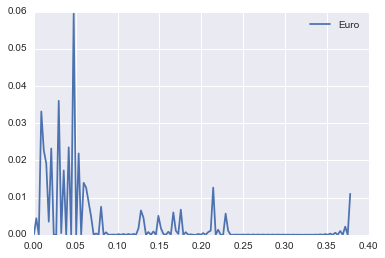

In [43]:
us = train[train['isUS'] == 1]
euro = train[train['isUS'] == 0]
#sns.kdeplot(us['cholesterol_100g'], label='US')
sns.kdeplot(euro['cholesterol_100g'], label='Euro')

In [44]:
sns.kdeplot(us['cholesterol'], label='US')
sns.kdeplot(euro['cholesterol'], label='Euro')

KeyError: 'cholesterol'

In [45]:
euro['energy_from_fat_100g'].max()

1420.0

In [ ]:
top_features = corr_df.iloc[0:4, :]['feature']
g = sns.pairplot(train[top_features])

In [ ]:
(X, y) = makeTrainingSet()
(Xtrain, Xtest, yTrain, yTest) = cross_validation.train_test_split(X, y)
clf = LogisticRegression(class_weight='balanced')
clf.fit(Xtrain, yTrain)
print('F1 Score: {}'.format(f1_score(yTest.values, clf.predict(Xtest.values))))
print('AUC: {}'.format(roc_auc_score(clf.predict(Xtest.values), yTest.values)))
print('Precision: {}'.format(precision_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Recall: {}'.format(recall_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))

We might as well be guessing randomly. Particularly, the precision score indicates we're making many false positive errors, predicting European foods as US foods.

In [ ]:
clf = rf(class_weight='balanced', max_depth=5)
clf.fit(Xtrain, yTrain)
print('F1 Score: {}'.format(f1_score(yTest.values, clf.predict(Xtest.values))))
print('AUC: {}'.format(roc_auc_score(clf.predict(Xtest.values), yTest.values)))
print('Precision: {}'.format(precision_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Recall: {}'.format(recall_score(ytrue=yTest.values,y_pred= clf.predict(Xtest.values))))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest.values,y_pred= clf.predict(Xtest.values))))

In [ ]:
plt.scatter(train.energy_from_fat_100g, train.cholesterol_100g, c=train.isEuro)
plt.xlabel('energy from fat')
plt.ylabel('cholesterol')
plt.legend(loc='best')

In [46]:
X = train.drop(['isUS'], axis=1).values
y = train['isUS'].values
(Xtrain, Xtest, yTrain, yTest) = cross_validation.train_test_split(X, y, stratify=y)
clf = LogisticRegression()
sc = StandardScaler()
X = sc.fit_transform(X)
params = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
gs = GridSearchCV(clf, param_grid=params, scoring='roc_auc')
gs.fit(Xtrain, yTrain)

print('best C: {}'.format(gs.best_params_['C']))
print('best AUC: {}'.format(gs.best_score_))




best C: 100
best AUC: 0.7807087912670242


In [82]:
#preds = gs.predict(Xtest)
probas = gs.predict_proba(Xtest)
preds = [1 if x > 0.37 else 0 for x in probas[:, 1]]
print('Test Set AUC: {}'.format(roc_auc_score(preds, yTest)))
print('Accuracy: {}'.format(accuracy_score(y_true=yTest, y_pred= preds)))

Test Set AUC: 0.9544634491784633
Accuracy: 0.9678524916032627


In [81]:
confusion_matrix(y_true=yTest, y_pred= preds)

array([[13959,    27],
       [  448,   155]])

In [90]:
100 - (sum(yTest) / len(yTest) * 100)

95.866748920419496

In [100]:
(X_df, y) = makeTrainingSet()
coef_df = makeCoefDf(gs.best_estimator_, X_df)
coef_df.iloc[0:10, :]

,absVal,feature,value
47,2.078,cocoa_100g,-2.078
7,0.389,omega_3_fat_100g,-0.389
10,0.281,cholesterol_100g,0.281
14,0.179,polyols_100g,-0.179
30,0.130,vitamin_b12_100g,0.130
8,0.117,alpha_linolenic_acid_100g,-0.117
13,0.104,lactose_100g,-0.104
48,0.096,carbon_footprint_100g,-0.096
33,0.088,potassium_100g,0.088
6,0.085,polyunsaturated_fat_100g,0.085


In [106]:
print(train[train['isUS'] == 1].cocoa_100g.mean())
train[train['isUS'] == 0].cocoa_100g.mean()

0.024865312888520515


0.3447213185084552

In [83]:
def makeConfusionDf(true, pred):
    c = confusion_matrix(y_true=yTest, y_pred= preds) 
    return pd.DataFrame(c, columns=['Pred 0', 'Pred 1'], index=['Acutal 0', 'Acutal 1'])
makeConfusionDf(yTest, preds)

,Pred 0,Pred 1
Acutal 0,13977,9
Acutal 1,460,143


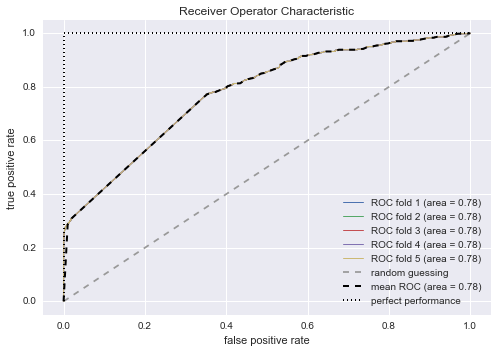

In [64]:
cv = cross_validation.StratifiedKFold(y, n_folds=5, random_state=2)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []


for i, (train, test) in enumerate(cv):
    probas = gs.predict_proba(Xtest)
    
    fpr, tpr, thresholds = roc_curve(yTest,
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
strat_df = makeCoefDf(clf, train.drop(['isUS'], axis=1))
strat_df.iloc[0:10, :]

### Let's explore the how US and Euro foods differ within food categories